# Part1. 기본 세팅

In [13]:
!pip install finance-DataReader

## 1. import library

In [14]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as ss
from IPython.display import set_matplotlib_formats
import plotly.express as px

In [15]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

In [16]:
# 시각화를 위한 폰트설정
import matplotlib.pyplot as plt

# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당
font_family = get_font_family()
# 폰트설정
plt.rc("font", family=font_family)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# 그래프 스타일 설정
plt.style.use("ggplot")

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Part 2. 파일 세팅

## 1. Stock Info

In [20]:
#코스피 지수 불러오기
ks_18 = fdr.DataReader('KS11', '2016-05-25', '2018-01-18')
ks_18

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2016-05-25,1960.51,1953.63,1964.91,1951.17,656870000.0,0.0118
2016-05-26,1957.06,1965.81,1967.45,1955.97,558260000.0,-0.0018
2016-05-27,1969.17,1962.33,1971.27,1959.75,523530000.0,0.0062
2016-05-30,1967.13,1969.72,1970.54,1955.49,550500000.0,-0.0010
2016-05-31,1983.40,1962.47,1984.18,1958.16,657040000.0,0.0083
...,...,...,...,...,...,...
2018-01-12,2496.42,2499.87,2500.87,2482.15,438780000.0,0.0034
2018-01-15,2503.73,2510.97,2513.30,2496.18,404550000.0,0.0029
2018-01-16,2521.74,2504.16,2524.55,2498.55,341610000.0,0.0072


In [34]:
park_dict = {
    'EG':'037370',
    '비트컴퓨터':'032850',
    '대유플러스':'000300',
    '대유에이텍':'002880',
    '서한':'011370'}

In [35]:
item_list_park = []
for item_code in park_dict.values():
    close = fdr.DataReader(item_code, '2016-05-25', '2018-01-18')['Close']
    item_list_park.append(close)

In [36]:
#테마주 종가 피벗테이블 만들기
park = pd.concat(item_list_park,axis=1)
park.columns = park_dict.keys()

park["ks_18"] = ks_18["Close"]

park_norm = (park - park.min()) / (park.max() - park.min())
park_norm

,EG,비트컴퓨터,대유플러스,대유에이텍,서한,ks_18
Date,,,,,,
2016-05-25,0.260444,0.719512,0.747793,0.641011,0.183761,0.055743
2016-05-26,0.253333,0.760163,0.741488,0.658242,0.158120,0.050290
2016-05-27,0.256000,0.727642,0.798235,0.738656,0.175214,0.069429
2016-05-30,0.252444,0.766260,0.785624,0.761631,0.149573,0.066205
2016-05-31,0.262222,0.750000,0.773014,0.784607,0.128205,0.091919
...,...,...,...,...,...,...
2018-01-12,0.404444,0.319106,0.029004,0.012062,0.679487,0.902723
2018-01-15,0.413333,0.353659,0.034048,0.000000,0.632479,0.914276
2018-01-16,0.431111,0.400407,0.000000,0.012062,0.641026,0.942740


In [37]:
#60일 이동평균선 만들기 위해 데이터 60일 뒤로 미루기
park_norm["EG_MA60"] = park_norm["EG"].rolling(60).mean()
park_norm["비트컴퓨터_MA60"] = park_norm["비트컴퓨터"].rolling(60).mean()
park_norm["대유플러스_MA60"] = park_norm["대유플러스"].rolling(60).mean()
park_norm["대유에이텍_MA60"] = park_norm["대유에이텍"].rolling(60).mean()
park_norm["서한_MA60"] = park_norm["서한"].rolling(60).mean()
park_norm["ks_18_MA60"] = park_norm["ks_18"].rolling(60).mean()

In [39]:
# UpperB, LowerB 구해 볼린저 밴드 그리기
# UpperB = 종가의 이동평균 + (표준편차 * 2)
# LowerB = 종가의 이동평균 - (표준편차 * 2)

park_norm["EG_stddev"] = park_norm["EG"].rolling(60).std()
park_norm["비트컴퓨터_stddev"] = park_norm["비트컴퓨터"].rolling(60).std()
park_norm["대유플러스_stddev"] = park_norm["대유플러스"].rolling(60).std()
park_norm["대유에이텍_stddev"] = park_norm["대유에이텍"].rolling(60).std()
park_norm["서한_stddev"] = park_norm["서한"].rolling(60).std()

park_norm["ks_18_stddev"] = park_norm["ks_18"].rolling(60).std()
park_norm["코스피지수_볼린저밴드_상한선"] = park_norm["ks_18_MA60"] + (park_norm["ks_18_stddev"] * 2)
park_norm["코스피지수_볼린저밴드_하한선"] = park_norm["ks_18_MA60"] - (park_norm["ks_18_stddev"] * 2)
park_norm.tail(60)


,EG,비트컴퓨터,대유플러스,대유에이텍,서한,ks_18,EG_MA60,비트컴퓨터_MA60,대유플러스_MA60,대유에이텍_MA60,서한_MA60,ks_18_MA60,EG_stddev,비트컴퓨터_stddev,대유플러스_stddev,대유에이텍_stddev,서한_stddev,ks_18_stddev,코스피지수_볼린저밴드_상한선,코스피지수_볼린저밴드_하한선
Date,,,,,,,,,,,,,,,,,,,,
2017-10-24,0.280889,0.148374,0.083228,0.063756,0.290598,0.893351,0.158193,0.178642,0.244515,0.135411,0.504630,0.745080,0.176491,0.051207,0.133028,0.063525,0.167224,0.075856,0.896792,0.593368
2017-10-25,0.297778,0.134146,0.084489,0.063756,0.264957,0.896528,0.162341,0.177320,0.238504,0.132778,0.496154,0.746159,0.176803,0.051317,0.131953,0.063160,0.166250,0.077552,0.901263,0.591056
2017-10-26,0.288889,0.132114,0.083228,0.069500,0.282051,0.877768,0.166237,0.176236,0.232472,0.130289,0.488533,0.747232,0.176976,0.051577,0.130612,0.062651,0.165393,0.078931,0.905094,0.589371
2017-10-27,0.297778,0.142276,0.085750,0.080988,0.269231,0.903055,0.170311,0.175762,0.226692,0.128183,0.480912,0.748869,0.177146,0.051759,0.129275,0.062139,0.164776,0.081133,0.911135,0.586603
2017-10-30,0.333333,0.121951,0.087011,0.086732,0.299145,0.911431,0.174904,0.174610,0.220723,0.126029,0.473789,0.750415,0.177750,0.052180,0.127270,0.061278,0.163210,0.083339,0.917093,0.583736
2017-10-31,0.368889,0.126016,0.094578,0.086732,0.384615,0.945411,0.180104,0.173865,0.215090,0.123827,0.468875,0.753640,0.178800,0.052554,0.125198,0.060252,0.161340,0.087059,0.927758,0.579521
2017-11-01,0.351111,0.144309,0.121059,0.095348,0.418803,0.997629,0.185141,0.173865,0.210172,0.122104,0.464245,0.757690,0.179297,0.052554,0.122942,0.059547,0.158658,0.092583,0.942856,0.572524
2017-11-02,0.386667,0.146341,0.117276,0.083860,0.401709,0.981651,0.190770,0.173391,0.204708,0.119854,0.458832,0.760940,0.180247,0.052674,0.119561,0.058369,0.155059,0.096937,0.954815,0.567066
2017-11-03,0.400000,0.168699,0.117276,0.080988,0.388889,1.000000,0.196548,0.173188,0.199348,0.117605,0.452778,0.764374,0.181320,0.052668,0.116044,0.057191,0.150435,0.101661,0.967696,0.561052


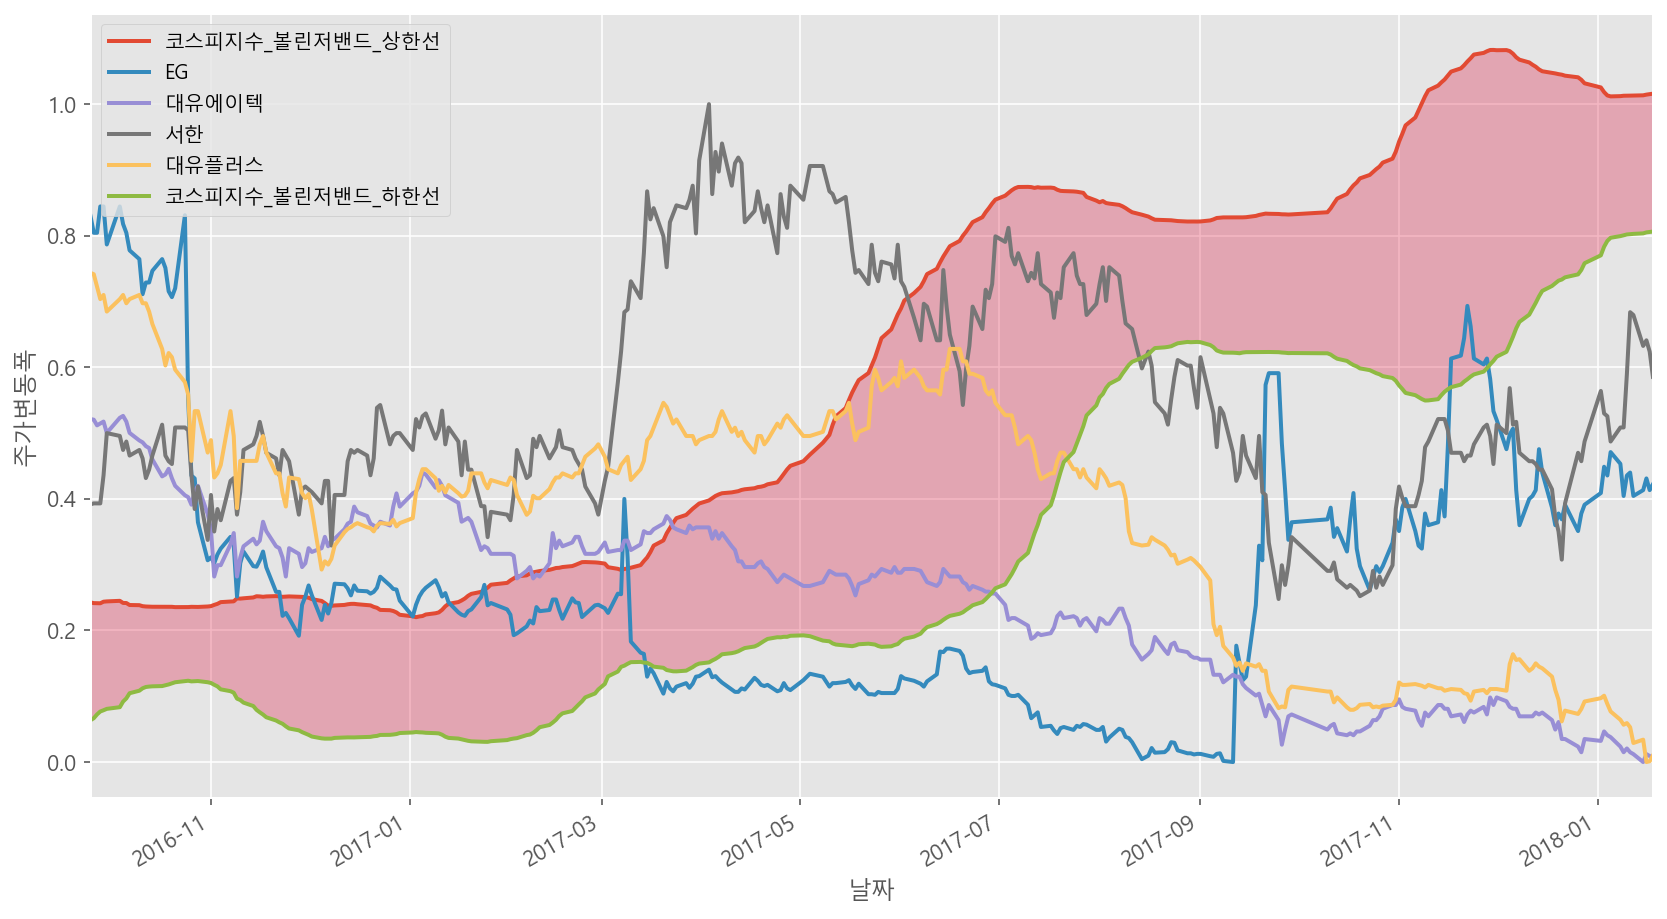

In [40]:
# 주가 기준
park_norm.reset_index(inplace=True)
park_norm['Date'] = pd.to_datetime(park_norm['Date'])
park_norm.set_index('Date', inplace=True)

park_norm[["코스피지수_볼린저밴드_상한선", 'EG', '대유에이텍', '서한', '대유플러스', "코스피지수_볼린저밴드_하한선"]].plot(linewidth=2.0, figsize=(14, 8), xlabel='날짜', ylabel='주가변동폭')
plt.fill_between(park_norm.index, park_norm.코스피지수_볼린저밴드_하한선, park_norm.코스피지수_볼린저밴드_상한선, alpha=0.3, color='crimson')
plt.rc('axes', labelsize=16)
plt.xlim('2016-09-25', '2018-01-18')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.rcParams['axes.facecolor'] = 'e5e5e5'
plt.show()